In [2]:
from copy import deepcopy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from Bio import Phylo, AlignIO

# Building a phylogenetic tree

To investigate evolutionary relationships between sequences in the alignment, we have to reconstruct the phylogenetic tree that approximates the evolutionary history of the viruses whose genomes we are analyzing. There are several commonly used tools for this, including

 - IQtree
 - RAxML
 - FastTree

We will use IQtree here, which can again be installed with `conda` via `conda install -c bioconda iqtree`. 

We can call IQtree (the program has looooots of options) via 
```bash
iqtree -s <input_alignment> -m GTR
```
The flag `-m GTR` tells IQtree to use a general-time-reversible substitution model.

After running the command, you'll find a number of files in your directory. 

```txt
<input_alignment>.fasta.bionj
<input_alignment>.fasta.ckp.gz
<input_alignment>.fasta.iqtree
<input_alignment>.fasta.log
<input_alignment>.fasta.mldist
<input_alignment>.fasta.treefile
```
Some of the are log files, or checkpoints to restart the analysis. The file we care most about is the file ending in `.treefile`. It contains the reconstructed tree in [`newick` format](https://en.wikipedia.org/wiki/Newick_format). 




## visualizing the tree

There are many excellent tools for visualizing phylogenetic tree. A very convenient one is [Auspice](https://auspice.us/), which is a web-based tool that allows you to visualize and explore phylogenetic trees interactively.

After changing the file extension of the `.treefile` to `.nwk`, upload the file and explore the tree.

Phylogenetic analysis often require integrating the phylogenetic tree with other information such as phenotype, geographic location, collection date... For the data at hand, you can also upload the metadata `csv` file generated previously, which lets you also color the tree by metadata.

![auspice](assets/auspice.png)

# Manipulating trees with Biopython

Biopython provides a library with a number of very useful basic function that allow you to work with phylogenetic trees.

Let's load an visualize the tree. You can use the `read` and `draw` function for this.

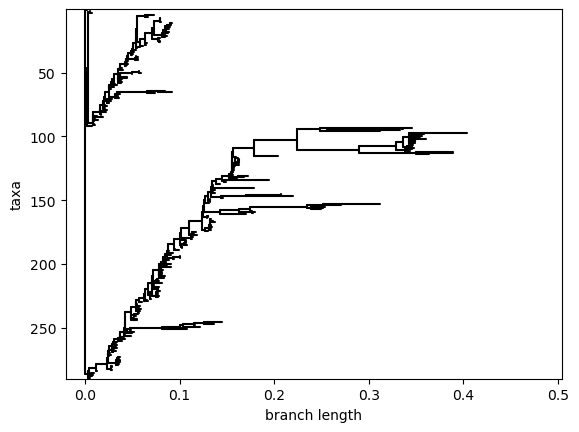

In [3]:
tree = Phylo.read("results/tree.nwk", "newick")

Phylo.draw(tree, label_func=lambda x: None)

### Ladderization

"Ladderizing" a tree involves sorting the children of each node such that the total number of subtending tips of each clade are ascending or descending. From a topological perspective, tree with rotated tips are equivalent. For display purposes, it often makes sense to decide on a particular ordering. Biophytion implements a ladderize routine.

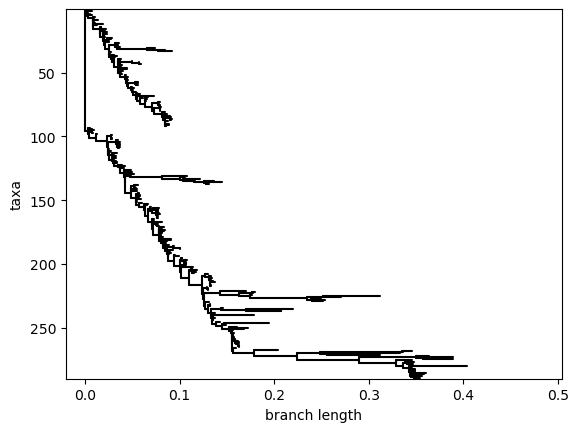

In [4]:
tree.ladderize()
Phylo.draw(tree, label_func=lambda x: None)

## Tree traversal

Unlike lists, trees are not linear data structures, but rather hierarchical data structures. Many of the algorithms that operate on trees require you to visit all nodes, but there is no single order in which to do this, and the order often matters.

There are several common ways to [traverse a tree](https://en.wikipedia.org/wiki/Tree_traversal):

 - **pre-order**: visit the parents before its children, starting at the root.
   This is often useful if the information needed at a node can be calculated from the information of its parent. (E.g. distance from the root).
 - **post-order**: visit children before its parent
   Useful if the information needed at a node can be calculated from the information of its children. (E.g. number of leaves below a node).
 - level or **breadth-first** traversal: root -> children of the root -> grand-children of the root -> ...

![tree traversal](assets/tree_traversal.png)
![level traversal](assets/level_traversal.png)

Pre-order and post-order traversal are at the heart of many efficient recursive algorithms.


### Simple example: calculate the number of leafs below each node. 

If we want to calculate the number of leafs below each internal node, we can use a post-order traversal. We can assign to each terminal node `n_leaves=1`, and for each internal node, we can sum the number of leaves of its children.


In [5]:
def calculate_n_leaves(tree):
    """Assign the number of leaves to each internal node"""
    T = deepcopy(tree)
    for node in T.find_clades(order="postorder"):
        if node.is_terminal():
            node.n_leaves = 1
        else:
            node.n_leaves = sum(child.n_leaves for child in node.clades)
    return T

T = calculate_n_leaves(tree)
print("total n. leaves:", T.root.n_leaves)

total n. leaves: 289


### Simple example: calculate the distance to the root.

If we want to calculate the distance of each internal node to the root, we can use a pre-order traversal. We can assign `distance=0` to the root, and for each other node we can set its `distance` equal to the distance of its parent plus the node branch length.

In [6]:
def calculate_root_to_tip_distance(tree):
    T = deepcopy(tree)

    T.root.distance = 0
    for node in T.get_nonterminals(order="preorder"):
        for child in node.clades:
            child.distance = node.distance + child.branch_length
    
    return T

# calculate root-to-tip distances
T = calculate_root_to_tip_distance(tree)
rtt_distances = {l.name: l.distance for l in T.get_terminals()}
print("root-to-tip distances:")
print(rtt_distances)
    

root-to-tip distances:
{'CY039167.1': 0.0025668441, 'CY118802.1': 0.0069190078999999995, 'CY007403.1': 0.0033521175999999997, 'CY002760.1': 0.0057219532, 'CY019157.1': 0.0069007012, 'CY008380.1': 0.0104611023, 'CY039199.1': 0.009872790199999999, 'CY008075.1': 0.008690483199999998, 'OR721235.1': 0.014029583599999996, 'CY105446.1': 0.009873500299999997, 'EU856997.1': 0.010466847699999999, 'EU100715.1': 0.0188149673, 'CY019835.1': 0.012248677399999998, 'CY038911.1': 0.0170001066, 'CY025755.1': 0.0169987016, 'CY036967.1': 0.021748318099999997, 'CY105574.1': 0.021157888299999997, 'CY068609.1': 0.023517085799999997, 'FJ686922.1': 0.0211459282, 'FJ686919.1': 0.023517416800000003, 'FJ532068.1': 0.0205557252, 'CY037823.1': 0.0211414144, 'OR717643.1': 0.0290336198, 'CY106584.1': 0.0272509628, 'CY115568.1': 0.0248795707, 'CY068113.1': 0.024879574399999996, 'CY160928.1': 0.0357666917, 'CY162640.1': 0.0351772602, 'CY163072.1': 0.0345843649, 'CY181785.1': 0.036956288799999994, 'MK587475.1': 0.073794

# Consistency check: alignment distance vs tree distance

In [7]:
from itertools import combinations


aln = AlignIO.read("results/h3n2_coding.aln.fa", "fasta")
ids = [rec.id for rec in aln]
A = np.array(aln)
aln_divergence = []
for i, j in combinations(range(len(ids)), 2):
    idxi = ids[i]
    idxj = ids[j]
    if idxi > idxj:
        idxi, idxj = idxj, idxi
    seqi = A[i]
    seqj = A[j]
    div = np.mean(seqi != seqj)
    aln_divergence.append({
        "id1": idxi,
        "id2": idxj,
        "aln_divergence": div,
    })
aln_divergence = pd.DataFrame(aln_divergence).set_index(["id1", "id2"])
aln_divergence


# calculate tree distances
tree_distances = []
for i, j in combinations(tree.get_terminals(), 2):
    idxi = i.name
    idxj = j.name
    if idxi > idxj:
        idxi, idxj = idxj, idxi
    dist = tree.distance(i, j)
    tree_distances.append({
        "id1": idxi,
        "id2": idxj,
        "tree_distance": dist,
    })
tree_distances = pd.DataFrame(tree_distances).set_index(["id1", "id2"])

In [8]:
# merge the two dataframes
dist = aln_divergence.join(tree_distances)


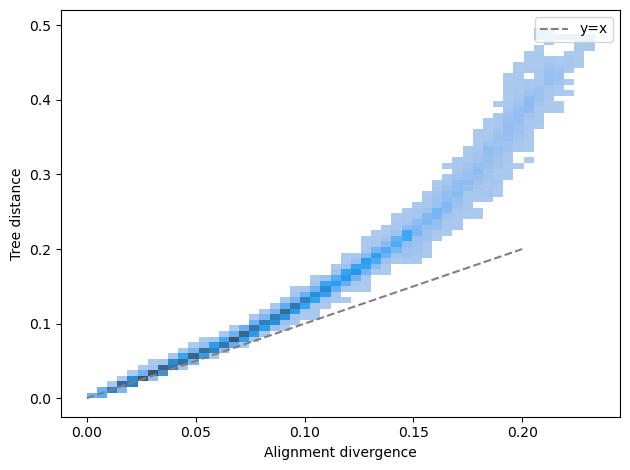

In [9]:
sns.histplot(data=dist, x="aln_divergence", y="tree_distance")
# plot diagonal
plt.plot([0, 0.2], [0, 0.2], color="gray", linestyle="--", label="y=x")
plt.xlabel("Alignment divergence")
plt.ylabel("Tree distance")
plt.legend()
plt.tight_layout()
plt.show()

# Rooting a tree

- time-reversible models: unrooted trees
- picking a root: choosing the direction of time
- different rooting methods
  - midpoint rooting: if the common ancestor is far away in the past.
  - outgroup rooting: if you have a distant outgroup
- consistency check: time vs root-to-tip distance

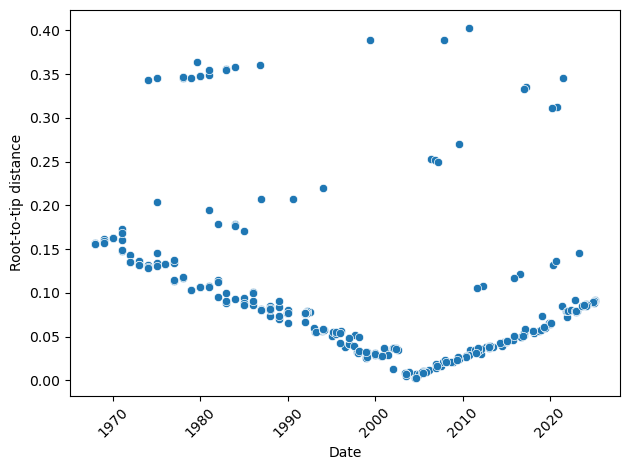

In [10]:
# load metadata
metadata = pd.read_csv("results/h3n2_metadata.csv", parse_dates=["date"], index_col=0)

def rtt_dist_vs_date_scatterplot(tree, metadata):
    # calculate root-to-tip distances
    depths = {k.name: v for k, v in tree.depths().items()}

    idxs = metadata.index
    date = metadata["date"]
    rtt_dist = [depths[idx] for idx in idxs]

    sns.scatterplot(x=date, y=rtt_dist)
    plt.xticks(rotation=45)
    plt.xlabel("Date")
    plt.ylabel("Root-to-tip distance")
    plt.tight_layout()
    plt.show()

rtt_dist_vs_date_scatterplot(tree, metadata)



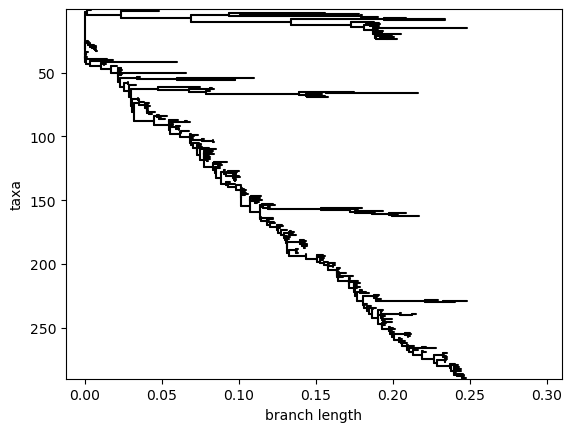

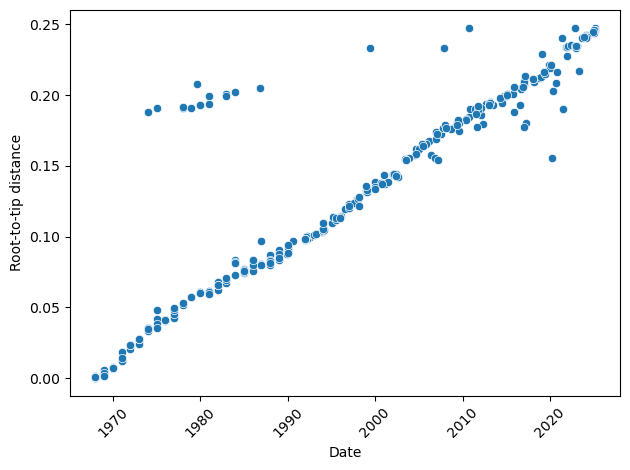

1

In [17]:
# we can use one of the original Hong-Kong sequences as an outgroup
outgroup = "CY033545.1"

tree.root_at_midpoint()
tree.ladderize()
Phylo.draw(tree, label_func=lambda x: None)

rtt_dist_vs_date_scatterplot(tree, metadata)

# save rooted tree
Phylo.write(tree, "results/tree_rooted.nwk", "newick")

In [19]:
metadata.sort_values("date").head()

,description,date,country,len,ambiguous,collection_year,depth
accession,,,,,,,
CY033017.1,Influenza A virus (A/Hong Kong/1-4/1968(H3N2))...,1968-01-01,Hong Kong,1720,0,1968,0.000041
CY033089.1,Influenza A virus (A/Hong Kong/1-1-MA21-3/1968...,1968-01-01,Hong Kong,1722,0,1968,0.001216
CY033025.1,Influenza A virus (A/Hong Kong/1-5/1968(H3N2))...,1968-01-01,Hong Kong,1720,0,1968,0.000629
CY033009.1,Influenza A virus (A/Hong Kong/1-2/1968(H3N2))...,1968-01-01,Hong Kong,1719,0,1968,0.000629
CY032977.1,Influenza A virus (A/Hong Kong/1-1-MA-20A/1968...,1968-01-01,Hong Kong,1722,0,1968,0.001801


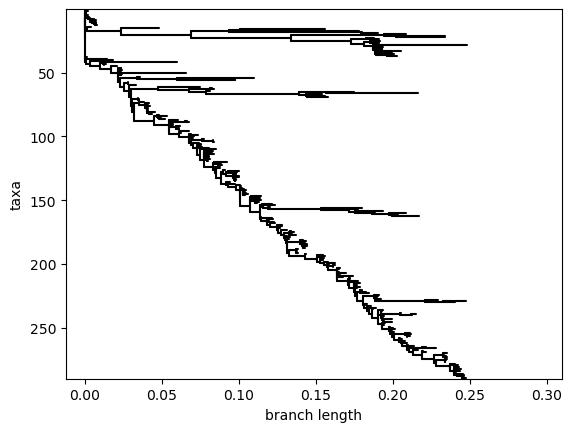

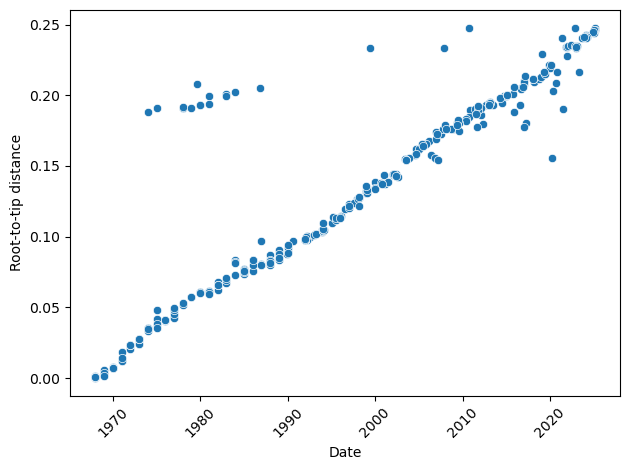

1

In [20]:
# we can use one of the original Hong-Kong sequences as an outgroup
outgroup = "CY033017.1"

tree.root_with_outgroup(outgroup)
tree.ladderize()
Phylo.draw(tree, label_func=lambda x: None)

rtt_dist_vs_date_scatterplot(tree, metadata)

# save rooted tree
Phylo.write(tree, "results/tree_rooted.nwk", "newick")

# Parsimonious ancestral state reconstruction: Fitch-parsimony

In [21]:
leaves_states = metadata["country"].to_dict()
# set the states of the leaves

def fitch_parsimony(tree, leaves_states):

    # set state of the leaves
    for leaf in tree.get_terminals():
        leaf.state = set([leaves_states[leaf.name]])
    
    # postorder traversal
    for node in tree.get_nonterminals(order="postorder"):
        # get the states of the children
        children_states = [child.state for child in node.clades]
        # find the intersection of the states
        intersection = set.intersection(*children_states)
        # if there is no intersection, take the union
        if not intersection:
            node.state = set.union(*children_states)
        else:
            node.state = intersection

    print("Preorder traversal terminated")
    print("Root states:", tree.root.state)

    # set the state of the root by picking one of the possible states
    tree.root.state = tree.root.state.pop()
    print("Root state set to:", tree.root.state)
    tree.root.transition = ""

    # preorder traversal
    for node in tree.get_nonterminals(order="preorder"):
        for child in node.clades:
            # if the child state is not in the node state, set the node state to the child state
            if node.state in child.state:
                child.state = node.state
                child.transition = ""
            else:
                child.state = child.state.pop()
                child.transition = f"{node.state} -> {child.state}"
    
    print("Preorder traversal terminated")
            
fitch_parsimony(tree, leaves_states)


Preorder traversal terminated
Root states: {'Hong Kong'}
Root state set to: Hong Kong
Preorder traversal terminated


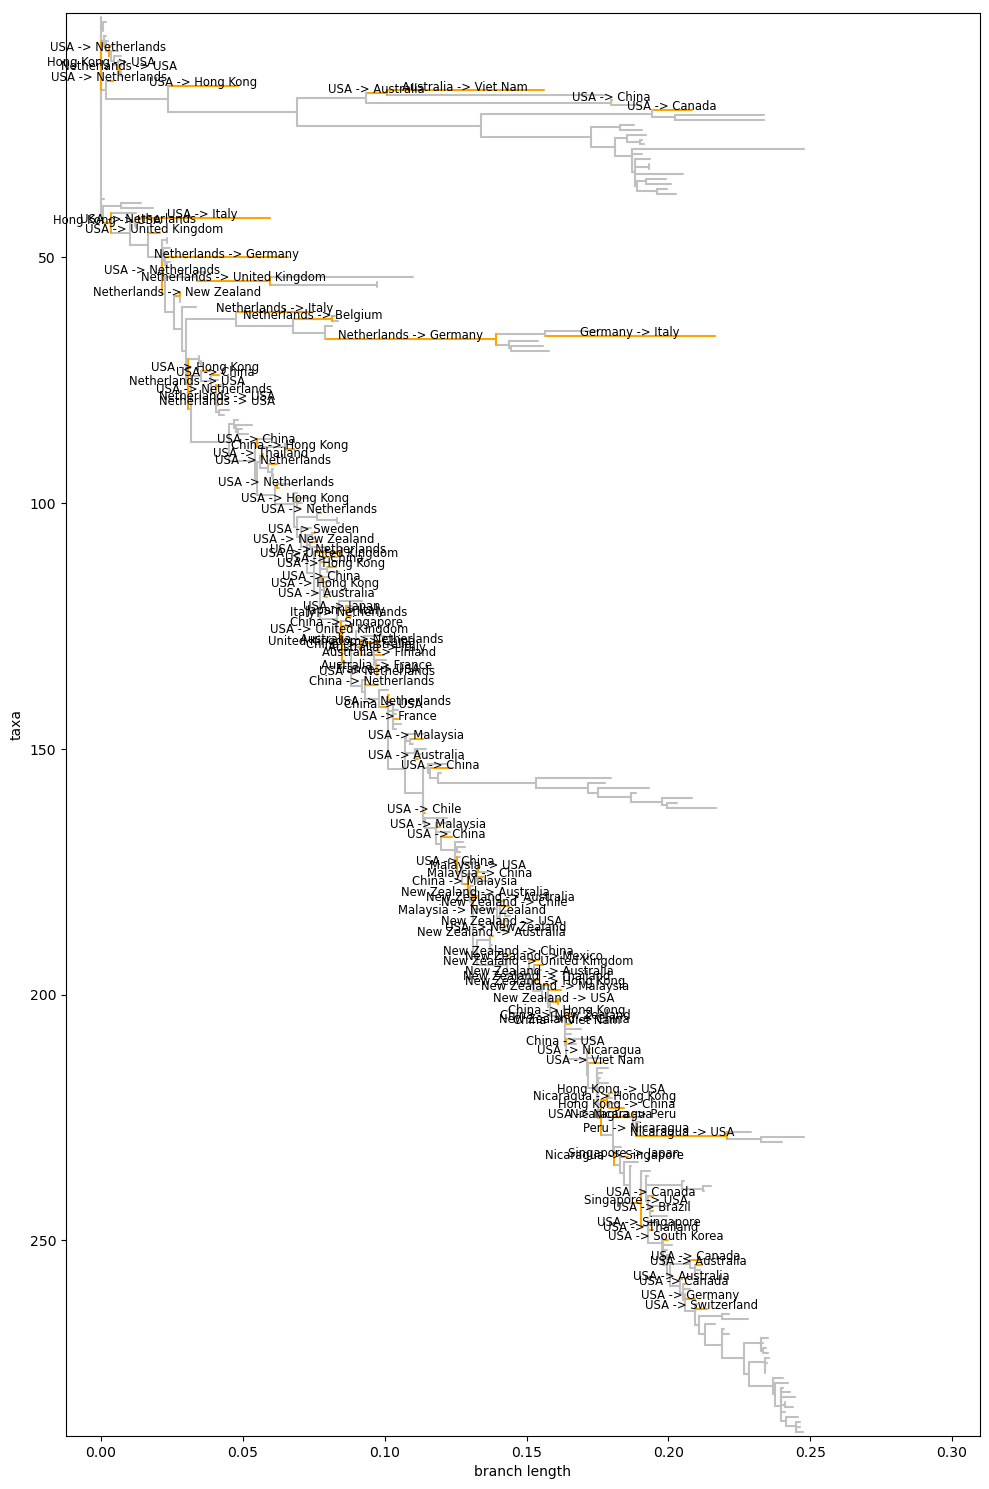

In [22]:
# color tree by transition state
tree_cpy = deepcopy(tree)
# set the color of the nodes based on the transition state
tree_cpy.root.color = "silver"
for node in tree_cpy.get_nonterminals():
    for child in node.clades:
        if child.transition:
            child.color = "orange"
        else:
            child.color = "silver"

fig, ax = plt.subplots(figsize=(10, 15))
Phylo.draw(tree_cpy, branch_labels=lambda n:n.transition, label_func=lambda n:'', axes=ax, do_show=False)
plt.tight_layout()
plt.show()


### Problems with this approach

- we don't really know the directionality of the tree. The tree isn't properly rooted (earlier sequences are far to the right)
- the sampling of viruses is very biased
- the algorithms treats each country equally likely, but a virus is much more likely to be from a big rather than a small country. 

## Root vs unrooted trees
Trees inferred by the canonical tree-building programs are typically "rooted", meaning they have singled out a particular node in the tree to act as the "parent" of all other nodes. However, the models of evolution used to infer the tree are typically "time reversible", meaning they don't differentiate between past and future and the likelihood of the tree does not depent on the choice of root. And while tree-building programs return a rooted tree, these trees are typically rooted arbitrarily.

The trees on the left and right below are the same trees!

![rooted tree example](assets/tree_rooted_example.png)
![unrooted tree example](assets/tree_unrooted_example.png)


### Common ways of picking a root

#### Midpoint rooting
Midpoint rooting picks the root to be half-way between the two tips that are furthest away of each other.
This choice of root is often natural when the samples have evolved from a common ancestor at similar rates. In this case you expect all tips to have a similar distance from the tree root and the midpoint between the two most diverged tips is an approximation of that. Variations of mid-point rooting minimize the variance if root-to-tip distance.  


#### Outgroup rooting

Another common way of rooting a tree is by using an outbreak. To do so, one typically adds a sequence that is clearly outside of the group of interest (if you were investigating mice, you could use a sequence from a rat as an outgroup). All sequences from the ingroup should form one clade and the point where the outgroup joins the ingroup is a good estimate of the common ancestor of the ingroup. 

See this illustration from [U Manchester](http://www.bioinf.man.ac.uk/resources/phase/manual/node59.html)

![outgroup rooting](assets/outgroup_rooting.png)


### Rapidly evolving viruses

In some cases, viruses evolve rapidly enough that they accumulate significant numbers of mutations over a few years and we can follow their evolution in real time. Example include SARS-CoV-2, Influenza viruses, and other RNA viruses. They typically accumulate between 10 and 40 mutations per genome per year. In these cases, we expect the distance of the individual sequennces from the root of the tree to increase with their sampling date: later sequences should have more differences compared to the ancestor. We can use this expectation to estimate the root. Specifically, we expect that the distance $d_i$ of genome $i$ from the ancestor should grow linearly with the time $t_i - T_{MRCA}$ since the common ancestor 
$$
d_i = \mu (t_i - T_{MRCA}) + \epsilon
$$
where $\epsilon$ is captures the stochasticity of the process (more precisely, we expect the number of mutations $d_i$ to be Poisson distributed with mean $\mu (t_i - T_{MRCA})$. 


#### Optimization of the root position

The position of the root can be optimized efficiently without exhaustively searching for the minimum of 
$$
\sum_i (d_i - \mu(t_i-T_{MRCA}))^2
$$
for all possible choices of roots. The best-fitting slope $\mu$ serves as an estimate of the evolutionary rate, i.e. the number of mutations that a genome accumulates per unit time. 

Such a search for the root is implemented in several packages, including [TreeTime](https://treetime.biozentrum.unibas.ch/). This algorithm will place the root such that the root-to-tip vs time regression is straight:

![treetime](assets/treetime.png)

The slope of the regression line is an estimate of the evolutionary rate, that is the rate at which mutations accumulate in the sequences. 


Attempting to parse dates...
	Using column 'accession' as name. This needs match the taxon names in the tree!!
	Using column 'date' as date.
before optimization:


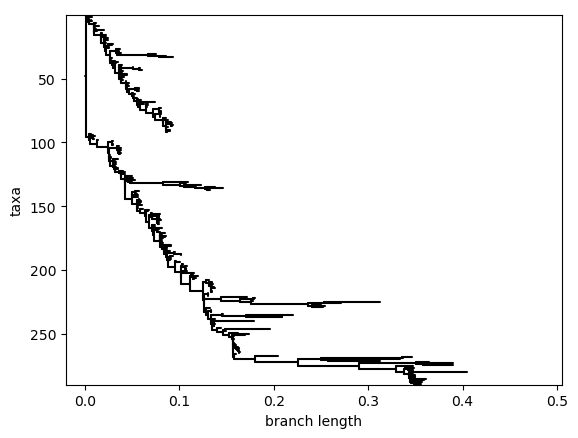

/home/marco/miniconda3/envs/teaching/lib/python3.13/site-packages/treetime/treeregression.py:563: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=fs*0.8)


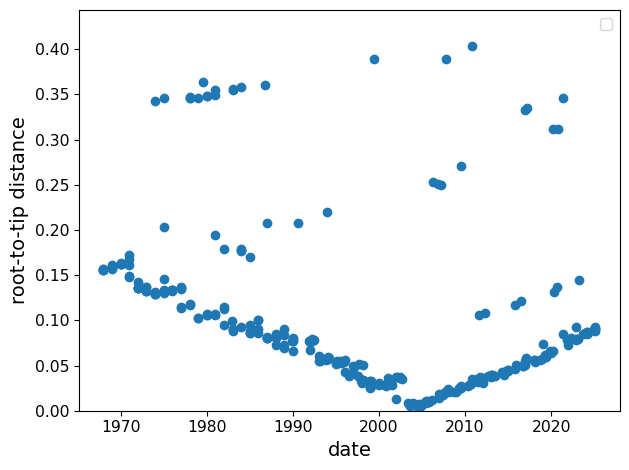

In [27]:
from treetime import TreeTime
from treetime.utils import parse_dates
from treetime.treetime import plot_vs_years

tree_fname = "results/tree.nwk"
aln_fname = "results/h3n2_coding.aln.fa"
metadata_fname = "results/h3n2_metadata.csv"
dates = parse_dates(metadata_fname, name_col="accession", date_col="date")
# dates = metadata["date"]
tt = TreeTime(gtr='Jukes-Cantor', tree = tree_fname, use_fft=False,
              aln = aln_fname, verbose = 1, dates = dates)

print("before optimization:")
Phylo.draw(tt.tree, label_func=lambda x:'')
tt.plot_root_to_tip()
plt.show()


5.97	TreeTime.reroot: with method or node: least-squares

5.97	TreeTime.reroot: rerooting will ignore covariance and shared ancestry.

6.35	###TreeTime.run: INITIAL ROUND

11.05	TreeTime.reroot: with method or node: least-squares

11.05	TreeTime.reroot: rerooting will ignore covariance and shared ancestry.

11.32	###TreeTime.run: rerunning timetree after rerooting

17.00	###TreeTime.run: ITERATION 1 out of 2 iterations

17.00	DEPRECATION WARNING. TreeTime.resolve_polytomies: You are resolving
     	polytomies using the old 'greedy' mode. This is not well suited for large
     	polytomies. Stochastic resolution will become the default in future
     	versions. To switch now, rerun with the flag `--stochastic-resolve`. To
     	keep using the greedy method in the future, run with `--greedy-resolve`

23.58	###TreeTime.run: ITERATION 2 out of 2 iterations


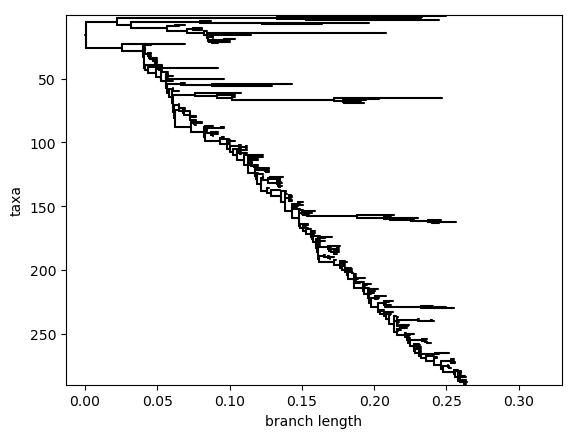

clock rate: 0.00389


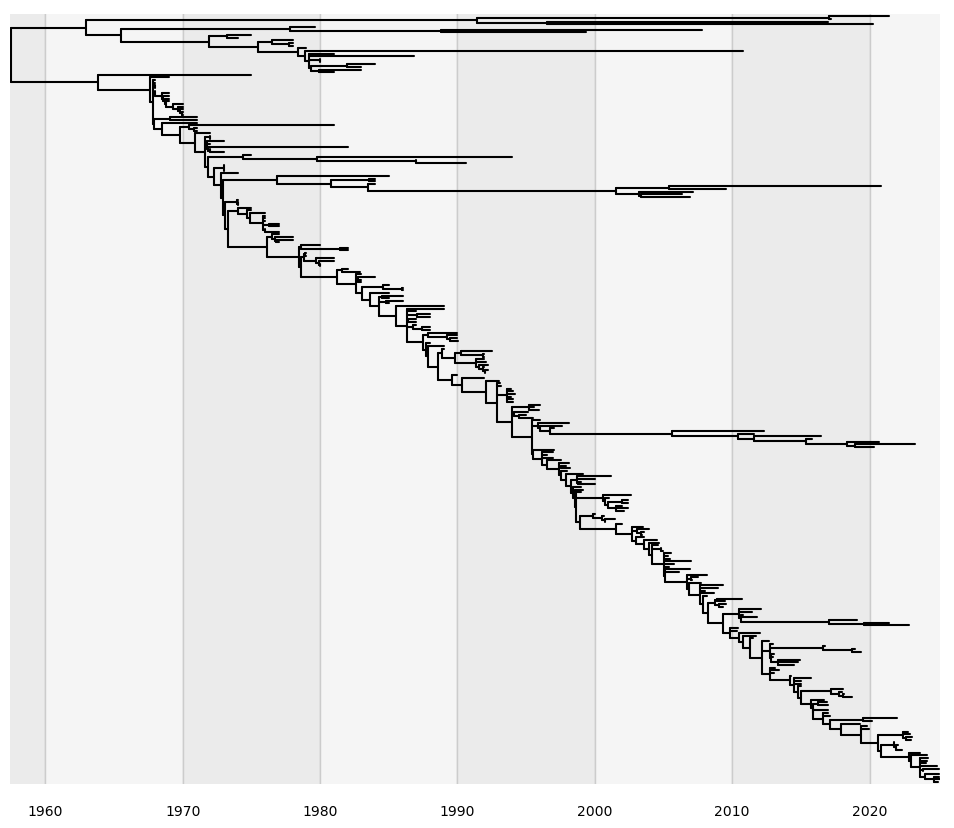

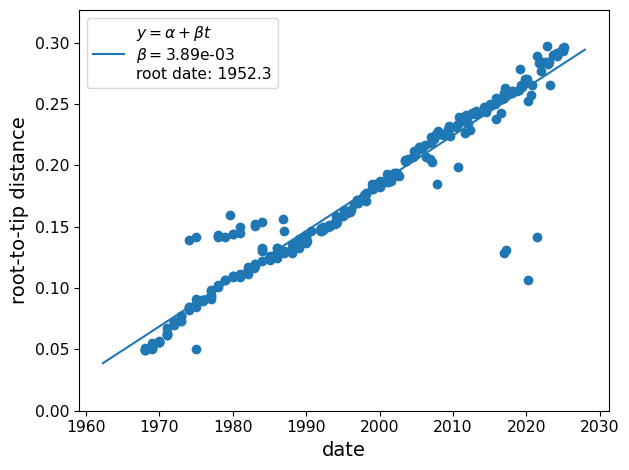

In [28]:
# rerooting can be done along with the tree time inference
tt.run(root="best", branch_length_mode='input', max_iter=2)

# each node is now at a position that correspond to the given or inferred date
# the units of branch length are still clock rate.
Phylo.draw(tt.tree, label_func=lambda x:'')

# treetime implements a convenience function to plot timetrees
plot_vs_years(tt, label_func=lambda x:"")

tt.plot_root_to_tip()
print("clock rate: %1.5f"%tt.date2dist.clock_rate)
plt.show()